In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("/kaggle/input/doctor/Doctor.csv")

In [3]:
df

,y,x1,x2,x3,x4,x5
0,0,14,4.30,1.00,2,3.72
1,0,12,11.54,8.49,3,40.28
2,0,14,5.84,2.47,3,56.00
3,1,11,14.70,6.60,1,57.41
4,0,21,5.10,3.48,1,83.00
5,0,12,6.14,3.09,1,62.57
6,1,17,5.05,1.14,3,22.16
7,1,12,11.30,8.85,1,12.00
8,0,14,3.30,1.20,3,110.00
9,1,19,6.60,4.30,1,2.96


## Построить описательную статистику ##

In [4]:
df.describe()

,y,x1,x2,x3,x4,x5
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,0.637931,16.327586,10.327931,7.141379,2.344828,45.135000
std,0.484796,3.213939,3.957742,3.749343,0.928151,53.956171
min,0.000000,11.000000,3.300000,1.000000,1.000000,0.800000
25%,0.000000,14.000000,6.375000,3.985000,1.000000,22.115000
50%,1.000000,16.000000,10.450000,6.835000,3.000000,38.935000
75%,1.000000,19.000000,13.400000,9.975000,3.000000,53.125000
max,1.000000,27.000000,19.000000,16.000000,3.000000,399.800000


## Построить базовую модель логистической регрессии с максимально возможным количеством предикторов ##

In [5]:
X_cols = ["x1", "x2", "x3", "x4", "x5"]
y_col = "y"

In [6]:
def get_model(df, X_cols, y_col, mod="logit"):
    X = df[X_cols]
    X = sm.add_constant(X)
    y = df[y_col]
    if mod == "logit":
        model = sm.Logit(y, X)
    elif mod == "probit":
        model = sm.Probit(y, X)
    results = model.fit()
    return results

In [7]:
results_logit = get_model(df, X_cols, y_col, "logit")

Optimization terminated successfully.
         Current function value: 0.341788
         Iterations 8


## Записать уравнение бинарной регрессии, используя оценки коэффициентов. ##

In [8]:
def print_equation(results):
    coefficients = results.params
    # Свободный член
    intercept = coefficients[0]
    # Коэффициенты при признаках
    slopes = coefficients[1:]
    
    equation = f"y = {intercept:.3f}"
    for i, slope in enumerate(slopes):
        equation += f" + ({slope:.3f}) * x{i+1}"

    print("Уравнение бинарной регрессии:")
    print(equation)

In [9]:
print_equation(results_logit)

Уравнение бинарной регрессии:
y = -10.942 + (0.455) * x1 + (0.809) * x2 + (-0.356) * x3 + (0.126) * x4 + (-0.032) * x5


## Протестировать значимость коэффициентов регрессии в отдельности. ##

In [10]:
def z_test(results):
    t_values = results.tvalues
    p_values = results.pvalues

    for i, (t, p) in enumerate(zip(t_values, p_values)):
        term = "Intercept" if i == 0 else f"x{i}"
        significance = "коэффициент значим" if p < 0.05 else "коэффициент не значим"
        print(f"{term}: z_statistic = {t:.3f}, pvalue = {p:.3f} ({significance})")

In [11]:
z_test(results_logit)

Intercept: z_statistic = -2.827, pvalue = 0.005 (коэффициент значим)
x1: z_statistic = 2.529, pvalue = 0.011 (коэффициент значим)
x2: z_statistic = 1.855, pvalue = 0.064 (коэффициент не значим)
x3: z_statistic = -0.852, pvalue = 0.394 (коэффициент не значим)
x4: z_statistic = 0.299, pvalue = 0.765 (коэффициент не значим)
x5: z_statistic = -1.605, pvalue = 0.109 (коэффициент не значим)


In [12]:
wald_test = results_logit.wald_test_terms()
print(wald_test)

                          chi2                P>chi2  df constraint
const    [[7.991796013612143]]  0.004698977918866599              1
x1        [[6.39398707438808]]  0.011450754899082684              1
x2      [[3.4401814511115596]]   0.06362870429737398              1
x3      [[0.7256260828272905]]    0.3943046297743855              1
x4     [[0.08933146270820487]]    0.7650287888373766              1
x5      [[2.5746084600694403]]   0.10859096761469102              1


## Проверить значимость регрессии в целом по критерию Вальда и максимального правдоподобия. ##

In [13]:
def max_likehood_test(df, X_cols, y_col, results):
    X = df[X_cols]
    X = sm.add_constant(X)
    y = df[y_col]

    # Сравнение с нулевой моделью
    null_model = sm.Logit(y, np.ones(len(y)))  # Нулевая модель без предикторов
    null_results = null_model.fit(disp=0)  # disp=0 отключает вывод

    # Логарифмы правдоподобия
    llf_full = results.llf  # Логарифм правдоподобия полной модели
    llf_null = null_results.llf  # Логарифм правдоподобия нулевой модели

    # Статистика теста
    lrt_statistic = -2 * (llf_null - llf_full)
    p_value_lrt = stats.chi2.sf(lrt_statistic, df=X.shape[1]-1)  # df = количество предикторов
    print (f"lrt statistic: {lrt_statistic} pvalue: {p_value_lrt}")

In [14]:
max_likehood_test(df, X_cols, y_col, results_logit)

lrt statistic: 36.286093027206505 pvalue: 8.325157639650031e-07


## Построить доверительные интервалы для коэффициентов регрессии ##

In [15]:
def coef_conf_intervals(results):
    confidence_intervals = results.conf_int(alpha=0.05)
    print("Доверительные интервалы:")
    print(confidence_intervals)

In [16]:
coef_conf_intervals(results_logit)

Доверительные интервалы:
               0         1
const -18.528639 -3.355914
x1      0.102432  0.808508
x2     -0.045854  1.662881
x3     -1.174720  0.462956
x4     -0.701351  0.953744
x5     -0.070765  0.007056


## Провести сравнительный анализ логит и пробит моделей. ##

In [17]:
results_probit = get_model(df, X_cols, y_col, "probit")

Optimization terminated successfully.
         Current function value: 0.342187
         Iterations 7


In [18]:
print(results_logit.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   58
Model:                          Logit   Df Residuals:                       52
Method:                           MLE   Df Model:                            5
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                  0.4779
Time:                        09:02:07   Log-Likelihood:                -19.824
converged:                       True   LL-Null:                       -37.967
Covariance Type:            nonrobust   LLR p-value:                 8.325e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.9423      3.871     -2.827      0.005     -18.529      -3.356
x1             0.4555      0.180      2.529      0.011       0.102       0.809
x2             0.8085      0.436      1.855      0.0

In [19]:
print(results_logit.aic)

51.64742827612176


In [20]:
print(results_probit.summary())

                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                   58
Model:                         Probit   Df Residuals:                       52
Method:                           MLE   Df Model:                            5
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                  0.4773
Time:                        09:02:07   Log-Likelihood:                -19.847
converged:                       True   LL-Null:                       -37.967
Covariance Type:            nonrobust   LLR p-value:                 8.504e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.2387      2.132     -2.926      0.003     -10.418      -2.060
x1             0.2601      0.101      2.574      0.010       0.062       0.458
x2             0.4682      0.248      1.890      0.0

In [21]:
print(results_probit.aic)

51.69364070100063


## Построить таблицу сопряженности с пороговой вероятностью 0.5 ##

In [22]:
def get_conf_matrix(results, X_cols, y_col, prob):
    X = df[X_cols]
    X = sm.add_constant(X)
    y = df[y_col]
    
    # Прогнозирование вероятностей
    predicted_probabilities = results.predict(X)

    # Классификация на основе порога 0.5
    predicted_classes = (predicted_probabilities >= prob).astype(int)

    # Создание таблицы сопряженности
    confusion_mat = confusion_matrix(y, predicted_classes)

    # Преобразование в DataFrame для удобного отображения
    confusion_df = pd.DataFrame(confusion_mat, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

    print("\nТаблица сопряженности:")
    print(confusion_df)
    return confusion_mat


In [23]:
conf_matrix = get_conf_matrix(results_logit, X_cols, y_col, 0.5)


Таблица сопряженности:
          Predicted 0  Predicted 1
Actual 0           18            3
Actual 1            3           34


## Посчитать специфичность и чувствительность модели ##

In [24]:
def get_metrics(conf_matrix):
    # Получаем TP, TN, FP, FN
    TN, FP, FN, TP = conf_matrix.ravel()

    # Вычисление чувствительности и специфичности
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    print(f"sensitivity: {sensitivity} specificity: {specificity}")

In [25]:
get_metrics(conf_matrix)

sensitivity: 0.918918918918919 specificity: 0.8571428571428571


## Найти оптимальное пороговое значение вероятности предсказания. Построить таблицу сопряженности для этой вероятности, посчитать специфичность и чувствительность модели ##

In [26]:
def find_threshold(results, X_cols, y_col):
    X = df[X_cols]
    X = sm.add_constant(X)
    y = df[y_col]

    # Прогнозирование вероятностей
    predicted_probabilities = results.predict(X)

    # Вычисление ROC-кривой
    fpr, tpr, thresholds = roc_curve(y, predicted_probabilities)
    # Находим оптимальный порог
    optimal_threshold, fpr, tpr, thresholds = find_optimal_cutoff(y, predicted_probabilities)

    return optimal_threshold

    # Функция для нахождения оптимального порога
def find_optimal_cutoff(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    
    # Вычисляем метрики
    optimal_idx = np.argmax(tpr - fpr)  # Оптимальный порог по максимальной разнице между TPR и FPR
    optimal_threshold = thresholds[optimal_idx]
    
    return optimal_threshold, fpr, tpr, thresholds

In [27]:
prob = find_threshold(results_logit, X_cols, y_col)
print(f"Оптимальный порог: {prob:.4f}")

Оптимальный порог: 0.5376


In [28]:
conf_matrix = get_conf_matrix(results_logit, X_cols, y_col, prob)


Таблица сопряженности:
          Predicted 0  Predicted 1
Actual 0           18            3
Actual 1            3           34


## Если выборка большого объема, то можно предварительно разбить выборку на две части: тренировочная и тестовая выборки ##

In [29]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df[X_cols], df[y_col], test_size=0.2, random_state=42)

In [30]:
train_data = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
test_data = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
results_logit = get_model(train_data, X_cols, y_col, "logit")

Optimization terminated successfully.
         Current function value: 0.311932
         Iterations 8


In [31]:
print(results_logit.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   46
Model:                          Logit   Df Residuals:                       40
Method:                           MLE   Df Model:                            5
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                  0.5172
Time:                        09:02:07   Log-Likelihood:                -14.349
converged:                       True   LL-Null:                       -29.720
Covariance Type:            nonrobust   LLR p-value:                 1.053e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.5904      4.857     -2.180      0.029     -20.110      -1.071
x1             0.5508      0.231      2.382      0.017       0.098       1.004
x2             0.3006      0.682      0.440      0.6

## Построить ROC кривую, интерпретировать результаты ##

In [32]:
def roc_plot(X_test, y_test):
    X_test = sm.add_constant(X_test)  # Добавляем константу
    predicted_probabilities = results_logit.predict(X_test)

    # Вычисление ROC-кривой и AUC
    fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)
    roc_auc = auc(fpr, tpr)

    # Построение ROC-кривой
    plt.figure()
    plt.plot(fpr, tpr, label='ROC-кривая (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Ложный положительный уровень')
    plt.ylabel('Истинный положительный уровень')
    plt.title('ROC-кривая')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    print(f"AUC: {roc_auc:.4f}")

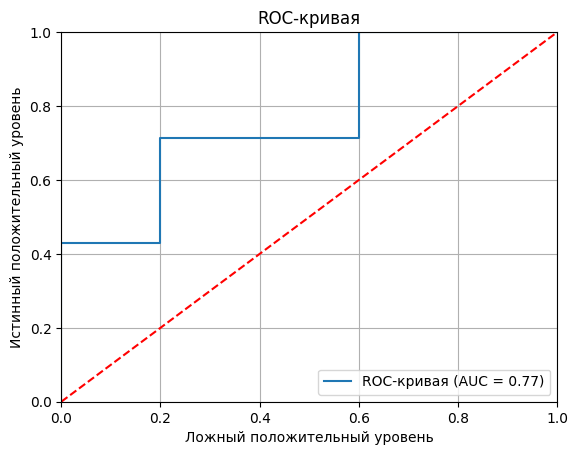

AUC: 0.7714


In [33]:
roc_plot(X_test, y_test)

## Попробовать улучшить логит или пробит модель с использованием коэффициента AIC ##

In [34]:
def calculate_aic(model_formula, data):
    model = sm.OLS.from_formula(model_formula, data).fit()
    return model.aic, model

def step_aic(data, dependent_var, independent_vars):
    best_aic = float('inf')
    best_model = None
    best_formula = None
    
    # Генерируем все возможные комбинации предикторов
    for k in range(1, len(independent_vars) + 1):
        for subset in itertools.combinations(independent_vars, k):
            formula = f"{dependent_var} ~ {' + '.join(subset)}"
            aic, model = calculate_aic(formula, data)
            if aic < best_aic:
                best_aic = aic
                best_model = model
                best_formula = formula

    return best_formula, best_model
    
def get_best_by_aic(df, X, y):
    best_formula, best_model = step_aic(df, y, X)
    print(f"Лучшая формула: {best_formula}")
    print(f"AIC: {best_model.aic}")

In [35]:
get_best_by_aic(train_data, X_cols, y_col)

Лучшая формула: y ~ x1 + x3 + x5
AIC: 39.508148430697304


In [36]:
X_cols = ["x1", "x3", "x5"]
train_data = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
results_logit = get_model(train_data, X_cols, y_col, "logit")

Optimization terminated successfully.
         Current function value: 0.316529
         Iterations 8


In [37]:
print(results_logit.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   46
Model:                          Logit   Df Residuals:                       42
Method:                           MLE   Df Model:                            3
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                  0.5101
Time:                        09:02:08   Log-Likelihood:                -14.560
converged:                       True   LL-Null:                       -29.720
Covariance Type:            nonrobust   LLR p-value:                 1.182e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.6698      3.463     -2.503      0.012     -15.458      -1.882
x1             0.5197      0.217      2.390      0.017       0.094       0.946
x3             0.4767      0.183      2.603      0.0

In [38]:
conf_matrix = get_conf_matrix(results_logit, X_cols, y_col, prob)


Таблица сопряженности:
          Predicted 0  Predicted 1
Actual 0           16            5
Actual 1            6           31
